<hr style="height: 5px; background-color: black; border: none;">

# Build OF-DFT PPs for high-pressure ( < 1 TPa ) / high-T systems

The phylosophy of the method is as follows:
 - Select a *reference PP*. This is an existing PP for OFDFT that works well at ambient pressures. For Al, here we use OEPP, which has $Z_{val}=3.0$.
 - The reference PP is associated to a value of $r_c$, the cutoff radius of the PP. We'll explain later how to get the value of $r_c$.
 - New PPs are generated for $r_c$ smaller than the reference one, so that they can handle shorter inter-atomic distances as it happens at very high pressures and temperatures.

<hr style="height: 5px; background-color: black; border: none;">

# Description of the method / theory
## Generate PP corrections

### Because the energy functional is:

$$
E = T_s[n] + E_{Hxc}[n] + \int v_{PP}(r)n(r)dr
$$

### then

$$
\mu=\frac{\delta E}{\delta n} = \frac{\delta Ts}{\delta n} + \frac{\delta E_{Hxc}}{\delta n} + v_{PP} \rightarrow v_{PP} = \mu - \left( \frac{\delta Ts}{\delta n} + \frac{\delta E_{Hxc}}{\delta n} \right)
$$

### Thus, a PP with $r_c=r_0$ can be corrected to work for $r_c=r_1<r_0$ as follows

$$
v_{PP}^{r_1}(r) = v_{PP}^{r_0}(r) + \delta v_{PP}(r)
$$

### And because:
$$
\mu=\frac{\delta E}{\delta n} = \frac{\delta Ts}{\delta n} + \frac{\delta E_{Hxc}}{\delta n} + v_{PP} \rightarrow v_{PP} = \mu - \left( \frac{\delta Ts}{\delta n} + \frac{\delta E_{Hxc}}{\delta n} \right)
$$

### we have

$$
\delta v_{PP} (r) = v_{T_s}^{r_0} + v_{Hxc}^{r_0} - v_{T_s}^{r_1} - v_{Hxc}^{r_1}+\text{constant}
$$

<hr style="height: 5px; background-color: black; border: none;">

# Implementation

### Import `sys`, `scipy`, `matplotlib`, `dftpy` and `sklearn` modules

In [1]:
import sys, os
sys.path.append(os.path.abspath('./PStudio/'))

In [2]:
from pstudio import AE, set_output
from pstudio.all_electron import AEwfc
#from pstudio.periodic_table import tuple_to_configuration
#from pstudio.TM import pseudize_TM
#from pstudio.RRKJ import pseudize_RRKJ
#from pstudio.vloc import generate_vloc_RRKJ, generate_vloc_TM
#from pstudio.pseudo import  calculate_vpot
#from pstudio.confinement import ConfinementPotential

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from scipy.ndimage import gaussian_filter

#from math import pi
from dftpy.formats import io
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import LEN_CONV
from dftpy.functional.pseudo import UPF

b2a = LEN_CONV['Bohr']['Angstrom']

### Get the All Electron (AE) solution for LDA Aluminum

In [3]:
set_output('-')
ae = AE('Al', config='[Ne] 3s2 3p1 3d0', xcname='LDA-py')


scalar relativistic atomic calculation for Al (Aluminum, Z=13)
configuration: 1s2 2s2 2p6 3s2 3p1 3d0, 13 electrons
exchange-correlation: LDA-python


In [4]:
ae.run(verbose=False)

2001 radial gridpoints in [1e-05,100]

Converged in 46 iterations

Energy contributions:
------------------------------------------------------------------------
Kinetic:     +241.944160 Ha     +6583.635930 eV 
Ionic:       -579.092969 Ha    -15757.922322 eV 
Hartree:     +112.858966 Ha     +3071.048874 eV 
XC:           -17.474140 Ha      -475.495575 eV 
------------------------------------------------------------------------
Total:       -241.763848 Ha     -6578.729399 eV 

state      eigenvalue      eigenvalue        rmax
------------------------------------------------------------------------
1s2        -55.282099 Ha -1504.302538 eV    0.079 
2s2         -3.950386 Ha  -107.495474 eV    0.498 
2p6         -2.561850 Ha   -69.711498 eV    0.427 
3s2         -0.287959 Ha    -7.835755 eV    2.056 
3p1         -0.102491 Ha    -2.788928 eV    2.639 
3d0          0.000000 Ha     0.000000 eV    0.000 unbound



### The $r$ coordinate for the AE system

In [5]:
r = ae.rgd.r

### Get a pseudovalence density based on the following predetermined form:
 - Supply $f(r)$, $f'(r)$ and $f''(r)$
 - The pseudodensity, $g(r)$ should be continuous at $r_c$ (including the derivatives): $g(r_c) = f(r_c),~ g'(r_c)=f'(r_c)\ldots$
 - Should go to zero at $r=0$
 - We propose: $g(r) = A r^4 + B r^3 + C r^2 + D r + E$

In [6]:
def valence_density(f, f_prime, f_double_prime, r, r_c):
    idx_rc = (np.abs(r - r_c)).argmin()
    f_rc = f[idx_rc]
    f_prime_rc = f_prime[idx_rc]
    f_double_prime_rc = f_double_prime[idx_rc]

    E = 0
    D = 0
    if r_c != 0:
        # Create the coefficient matrix and the right-hand side vector
        A_matrix = np.array([
            [r_c**4, r_c**3, r_c**2],
            [4 * r_c**3, 3 * r_c**2, 2 * r_c],
            [12 * r_c**2, 6 * r_c, 2]
        ])
        b_vector = np.array([f_rc, f_prime_rc, f_double_prime_rc])

        # Solve the linear system for A, B, and C
        A, B, C = np.linalg.solve(A_matrix, b_vector)
    else:
        A, B, C = 0, 0, 0  # Handle the case where r_c is zero to avoid division by zero

    # Define the g function for all r values
    g = np.zeros_like(r)
    mask_greater_equal_rc = r >= r_c
    mask_less_rc = r < r_c

    if np.any(mask_greater_equal_rc):
        g[mask_greater_equal_rc] = f[mask_greater_equal_rc]
    if np.any(mask_less_rc):
        r_less_rc = r[mask_less_rc]
        if len(r_less_rc) > 0:
            g_values_less_rc = A * r_less_rc**4 + B * r_less_rc**3 + C * r_less_rc**2 + D * r_less_rc + E
            if len(g_values_less_rc) == len(g[mask_less_rc]):
                g[mask_less_rc] = g_values_less_rc

    return g

### Read the OEPP PP:

In [7]:
upf = UPF('./Al_OEPP_PZ.UPF')
r_OEPP = upf.r
fac_OEPP = 4*np.pi*r_OEPP**2
fac_OEPP_c = fac_OEPP
fac_OEPP_c[0]=1.0
rho_OEPP = upf.atomic_density
vpp_OEPP = upf.v

### First, get derivatives of AE density

In [8]:
second_der = ae.rgd.spline_deriv2(ae.rho)
der = ae.rgd.spline_deriv1(ae.rho)

### Get the psudodensity for a given $r_c$ and the psudopotential for $r_c$

### The main approximation is 
$$
v_{T_s}(r) = v_{TF}(r)
$$

The reason for the approximation is purely numerical. Using vW would make the potential too noisy

In [9]:
def get_vpp_rc(rho_ae,drho_ae,d2rho_ae,r,rc):
    from pstudio.oncvpsp_routines.oncvpsp import hartree
    rho_v = valence_density(rho_ae, drho_ae, d2rho_ae, r, rc)
    N_v = ae.rgd.integrate(rho_v*4*np.pi*r*r)
    print("Number of valence electrons: ", N_v)
    rho_c = rho_ae - rho_v
    vhg = hartree(rho_v*4*np.pi, N_v, r)
    _, vxcg, _ = ae.calculate_xc(rho_v)
    vtfg = ae.calculate_tf(rho_v)
    #vvwg = ae.calculate_spline_vw(rho_v)
    A=1.0; B=0.0; vpp = A*vtfg + vhg + vxcg # + B*vvwg vW not included bc it is too noisy
    return vpp, rho_v, rho_c, N_v

In [101]:
vpp_e_13, rho_ae_valence_13, rho_ae_core_13, N_v_13 = get_vpp_rc(ae.rho,der,second_der,r,1.3)
vpp_e_14, rho_ae_valence_14, rho_ae_core_14, N_v_14 = get_vpp_rc(ae.rho,der,second_der,r,1.4)
vpp_e_20, rho_ae_valence_20, rho_ae_core_20, N_v_20 = get_vpp_rc(ae.rho,der,second_der,r,2.0)
vpp_e_24, rho_ae_valence_24, rho_ae_core_24, N_v_24 = get_vpp_rc(ae.rho,der,second_der,r,2.394726344522496) # found by bisection

Number of valence electrons:  4.454995140565998
Number of valence electrons:  4.104512472460816
Number of valence electrons:  3.2039712873196122
Number of valence electrons:  3.000000000000001


<hr style="height: 5px; background-color: black; border: none;">

### The valence density determined by `valence_density` retrieves $Z_{val}=3.0$ for $r_c=2.394726344522496 a_0$ (indicated by `24` hereafter)

<hr style="height: 5px; background-color: black; border: none;">

(-0.1, 5.0)

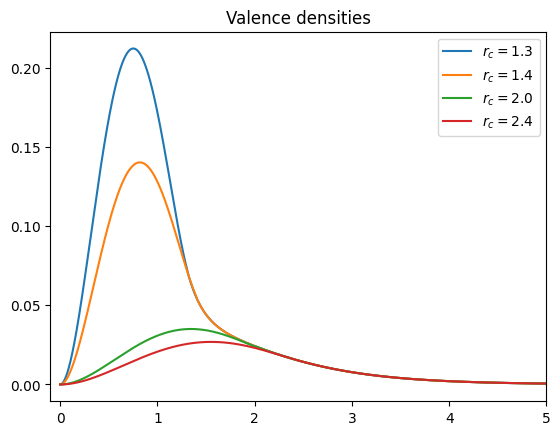

In [102]:
plt.plot(r,rho_ae_valence_13,label=r"$r_c = 1.3$")
plt.plot(r,rho_ae_valence_14,label=r"$r_c = 1.4$")
plt.plot(r,rho_ae_valence_20,label=r"$r_c = 2.0$")
plt.plot(r,rho_ae_valence_24,label=r"$r_c = 2.4$")
plt.legend(); plt.title("Valence densities"); plt.xlim([-0.1,5])

### Get the psudopotential corrections (from $r_c^0=2.4$ to $r_c^1<2.4$)

In [103]:
vpp_corr_20 = -vpp_e_20 + vpp_e_24
vpp_corr_14 = -vpp_e_14 + vpp_e_24
vpp_corr_13 = -vpp_e_13 + vpp_e_24
vpp_corr_10 = -vpp_e_10 + vpp_e_24

(-0.1, 5.0)

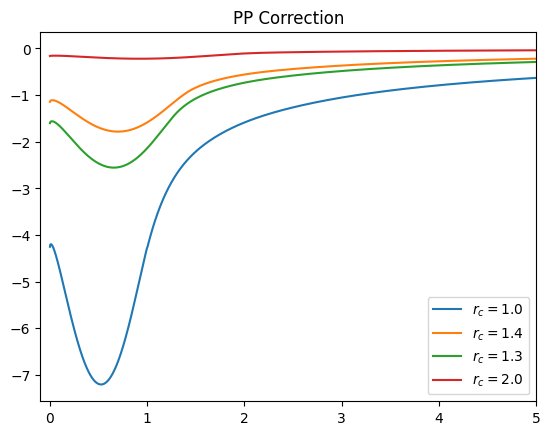

In [104]:
plt.plot(r,vpp_corr_10,label=r"$r_c = 1.0$")
plt.plot(r,vpp_corr_14,label=r"$r_c = 1.4$")
plt.plot(r,vpp_corr_13,label=r"$r_c = 1.3$")
plt.plot(r,vpp_corr_20,label=r"$r_c = 2.0$")
plt.legend(); plt.title("PP Correction"); plt.xlim([-0.1,5])

<hr style="height: 5px; background-color: black; border: none;">

### We may need to smooth $v_{PP}(r)$ in the general range $0<r<\frac{r_c}{2}$, which may be oscillatory.

<b><span style="color: red;">This is deactivated for now</span></b>

 - One thing to do would be to either impose smoothness

$$v_{PP}(0) = \arg\min_{v_{PP}(0)} \int |\nabla v_{PP}(r)|^2 dr$$

 - Alternatively, we could impose a physical condition on the pseudodensity

$$v_{PP}(0) = \arg\min_{v_{PP}(0)} \int \left|n[v_{PP}](r)-\text{constr.}\right| dr = 0$$


<hr style="height: 5px; background-color: black; border: none;">

### Interpolate $v_{PP}$ to grid of reference PP (in this case OEPP)

In [105]:
def interpolate_vpp(vpp,r,r_new):
    from scipy.interpolate import UnivariateSpline
    spline = UnivariateSpline(r, vpp, s=0) 
    vpp = spline(r_new)
    return vpp

In [106]:
vpp_corr_OEPP_20 = interpolate_vpp(vpp_corr_20,r,r_OEPP)
vpp_corr_OEPP_14 = interpolate_vpp(vpp_corr_14,r,r_OEPP)
vpp_corr_OEPP_13 = interpolate_vpp(vpp_corr_13,r,r_OEPP)
vpp_corr_OEPP_10 = interpolate_vpp(vpp_corr_10,r,r_OEPP)

### Write $v_{PP}$ to PSP8 file

In [107]:
def write_pp(filename,atomicnum,vpp_ref,vpp_corr,r,Z,N_v_corr):
    engine = PSP(None)
    engine.r = r
    engine.v = vpp_ref+vpp_corr
    engine._zval = Z + N_v_corr
    print ("Zval: ",engine._zval)
    engine.info['atomicnum'] = atomicnum # 13
    filename = filename + '.psp8'
    engine.write(filename)
    return filename+" written"

In [108]:
write_pp('Al_2.0',13,vpp_OEPP,vpp_corr_OEPP_20,r_OEPP,3.0,N_v_20-N_v_24)

Zval:  3.2039712873196113


'Al_2.0.psp8 written'

In [109]:
write_pp('Al_1.4',13,vpp_OEPP,vpp_corr_OEPP_14,r_OEPP,3.0,N_v_14-N_v_24)

Zval:  4.104512472460815


'Al_1.4.psp8 written'

In [110]:
write_pp('Al_1.3',13,vpp_OEPP,vpp_corr_OEPP_13,r_OEPP,3.0,N_v_13-N_v_24)

Zval:  4.454995140565997


'Al_1.3.psp8 written'

(0.0, 10.0)

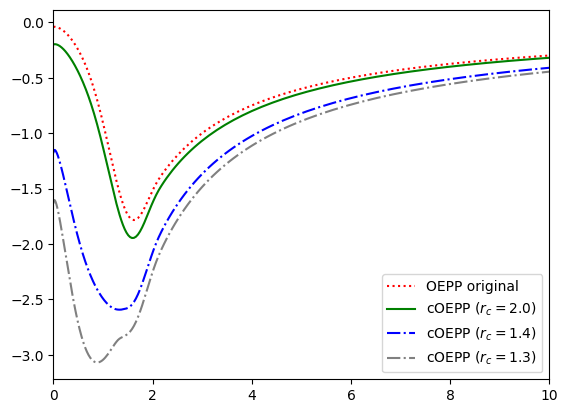

In [114]:
plt.plot(r_OEPP,vpp_OEPP,color='r',ls=":",label="OEPP original")
plt.plot(r_OEPP,vpp_OEPP+vpp_corr_OEPP_20,color='g',ls="-",label="cOEPP ($r_c = 2.0$)")
plt.plot(r_OEPP,vpp_OEPP+vpp_corr_OEPP_14,color='b',ls="-.",label="cOEPP ($r_c = 1.4$)")
plt.plot(r_OEPP,vpp_OEPP+vpp_corr_OEPP_13,color='gray',ls="-.",label="cOEPP ($r_c = 1.3$)")
plt.legend()
plt.xlim([0,10.0])
#plt.ylim(-10,1)

<hr style="height: 5px; background-color: black; border: none;">